In [2]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
import zipfile

In [4]:
def extract_data(_dir):
    for pic_type in ['color', 'grayscale', 'segmented']:
        with zipfile.ZipFile(f'{_dir}/{pic_type}.zip') as zf:
            zf.extractall(f'{_dir}/imgs/')

extract_data('data')

In [6]:
# Set up scaler.
scaler = StandardScaler()

def preprocess(data):
    if data is None:  # val/test can be empty
        return None
    # Read image files to pytorch dataset (only temporary).
    transform = transforms.Compose([
        transforms.Resize(64), 
        transforms.CenterCrop(64), 
        transforms.ToTensor()
    ])
    data = datasets.ImageFolder(data, transform=transform)

    # Convert to numpy arrays.
    images_shape = (len(data), *data[0][0].shape)
    images = np.zeros(images_shape)
    labels = np.zeros(len(data))
    for i, (image, label) in enumerate(data):
        images[i] = image
        labels[i] = label

    # Flatten.
    images = images.reshape(len(images), -1)

    # Scale to mean 0 and std 1.
    scaler.fit(images)
    images = scaler.transform(images)

    # Shuffle train set.
    images, labels = sklearn.utils.shuffle(images, labels)

    return [images, labels]

color_data = preprocess("data/imgs/color")
grayscale_data = preprocess("data/imgs/grayscale")
segmented_data = preprocess("data/imgs/segmented")

In [13]:
from sklearn.model_selection import train_test_split

CX_train, CX_test, Cy_train, Cy_test = train_test_split(color_data[0], color_data[1], test_size=0.2)
GX_train, GX_test, Gy_train, Gy_test = train_test_split(grayscale_data[0], grayscale_data[1], test_size=0.2)
SX_train, SX_test, Sy_train, Sy_test = train_test_split(segmented_data[0], segmented_data[1], test_size=0.2)

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [20]:
model.fit(CX_train, Cy_train)

RandomForestClassifier()

In [21]:
model.score(CX_test, Cy_test)

0.9393414211438474

In [24]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, font_size=14):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=range(3))
    ax.yaxis.set(ticks=range(3))
    ax.set_ylim(2.5, -0.5)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
    plt.show()

Score de treino: 1.0
Score de teste: 0.9393414211438474


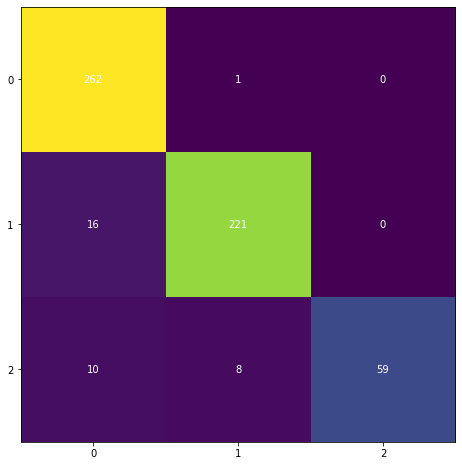

In [25]:
# Avaliando o modelo
from sklearn.metrics import classification_report, confusion_matrix

p_pred = model.predict_proba(CX_test)
y_pred = model.predict(CX_test)
score_train = model.score(CX_train, Cy_train)
score = model.score(CX_test, Cy_test)
conf_m = confusion_matrix(Cy_test, y_pred)
report = classification_report(Cy_test, y_pred)

# Analisando se houve overfitting
print(f'Score de treino: {score_train}')
print(f'Score de teste: {score}')

plot_confusion_matrix(conf_m)

In [26]:
print(report)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       263
         1.0       0.96      0.93      0.95       237
         2.0       1.00      0.77      0.87        77

    accuracy                           0.94       577
   macro avg       0.96      0.90      0.92       577
weighted avg       0.94      0.94      0.94       577

